**Calibration of the age-stratified deterministic model**

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load data

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-08-06,278,65,28,39,687,2,0.0,0.0,0,1.0,1
2020-08-07,285,69,27,28,686,4,0.0,0.0,0,1.0,3
2020-08-08,281,67,31,39,678,2,0.0,0.0,0,2.0,0
2020-08-09,285,69,20,14,684,4,1.0,0.0,0,1.0,2
2020-08-10,312,73,33,12,705,3,0.0,1.0,1,0.0,1


In [4]:
nonpublic_ts = pd.read_csv('../../data/interim/non_public/all_nonpublic_timeseries.csv', parse_dates=['DATE'])
# deceased_hosp = nonpublic_ts[['DATE','deceased_hosp']].groupby('DATE').sum()['2020-03-15':].reset_index()
# deceased_hosp['D_cumsum'] = deceased_hosp.deceased_hosp.cumsum()

In [8]:
nonpublic_ts.Arrondissement.unique()

array(['Antwerpen', 'Mechelen', 'Turnhout', 'Brussel-Hoofdstad',
       'Halle-Vilvoorde', 'Leuven', 'Nijvel', 'Brugge', 'Diksmuide',
       'Ieper', 'Kortrijk', 'Oostende', 'Roeselare', 'Tielt', 'Veurne',
       'Aalst', 'Dendermonde', 'Eeklo', 'Gent', 'Oudenaarde',
       'Sint-Niklaas', 'Aat', 'Charleroi', 'Bergen', 'Zinnik', 'Thuin',
       'Doornik-Moeskroen', 'Hoei', 'Luik', 'Verviers', 'Borgworm',
       'Hasselt', 'Maaseik', 'Tongeren', 'Aarlen', 'Bastenaken',
       'Marche-en-Famenne', 'Neufchâteau', 'Virton', 'Dinant', 'Namen',
       'Philippeville'], dtype=object)

In [5]:
nonpublic_ts.tail()

,Unnamed: 0,Arrondissement,Province,NIS,inhabitants,DATE,confirmed_cases,tested_cases,confirmed_per_tested_5days_window,hospitalised_IN,recovered,deceased_hosp,ICU,confirmed_cases_per_100k,hospitalised_IN_per_100k,recovered_per_100k,deceased_hosp_per_100k,ICU_per_100k
8941,11125,Philippeville,Namen,93000,66315.0,2020-08-01,0.0,89.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
8942,11126,Philippeville,Namen,93000,66315.0,2020-08-02,0.0,26.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
8943,11127,Philippeville,Namen,93000,66315.0,2020-08-03,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8944,11128,Philippeville,Namen,93000,66315.0,2020-08-28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8945,11129,Philippeville,Namen,93000,66315.0,2020-11-12,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# H_in = nonpublic_ts[['DATE','hospitalised_IN']].groupby('DATE').sum()['2020-03-15':].reset_index()

# fig,ax = plt.subplots()
# H_in.plot('DATE','hospitalised_IN', ax=ax)
# df_sciensano.reset_index().plot('DATE', 'H_in', ax=ax)

In [11]:
arrondissement = 'Gent'
readin_date = str(datetime.date.today()) #'2020-08-17'

In [12]:
arrond_ts = nonpublic_ts.pivot(index='DATE', columns='Arrondissement', values='hospitalised_IN')[arrondissement]

# Initialize the model

In [13]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

# Policies translated to checkpoints

chk_beta_pso = {   
    'time':  [lag_time],    
    'Nc':    [0.2 *Nc_home + ((1-0.70) *Nc_work + (1-0.80) *Nc_transport)],   
}

Hier geen school want alles dicht van 15 tot 22 maart!

chk_beta_MCMC = {   
    'time':  [lag_time],   
    'Nc':    [prevention *(1.0 *Nc_home + (1-0.60) *Nc_work + (1-0.70) *Nc_transport +(1-0.30) *Nc_others + (1-0.80) *Nc_leisure)],   
}

tot 20 april nog steeds geen school!

chk_ramp_MCMC also used for final plot

# Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

JV: 
- **lag_time = excess time?**
- sigma_H_in = variance on the data (**waarom moet dit geschat worden?**)

In [14]:
start_date = '2020-03-15'
end_beta = '2020-03-22'
end_ramp = '2020-04-20'

## Initial guess with PSO

In [15]:
# define dataset
data=[arrond_ts[start_date:end_beta]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.
New best for swarm at iteration 1: [10.37414444 30.          0.03700948] 18.981434519118864
Best after iteration 1: [10.37414444 30.          0.03700948] 18.981434519118864
Best after iteration 2: [10.37414444 30.          0.03700948] 18.981434519118864
New best for swarm at iteration 3: [ 6.67437276 30.          0.0399198 ] 15.822670227372399
Best after iteration 3: [ 6.67437276 30.          0.0399198 ] 15.822670227372399
New best for swarm at iteration 4: [ 3.03917891 30.          0.0390831 ] 11.462358140929616
Best after iteration 4: [ 3.03917891 30.          0.0390831 ] 11.462358140929616
Best after iteration 5: [ 3.03917891 30.          0.0390831 ] 11.462358140929616
Best after iteration 6: [ 3.03917891 30.          0.0390831 ] 11.462358140929616
New best for swarm at iteration 7: [ 2.1982485  30.          0.03903813] 11.190829794103687
Best after iteration 7: [ 2.1982485  30.          0.03903813] 11.190829794103687
New best for swarm at iteration 8: [ 2.2665

In [16]:
lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

## MCMC calibration

In [17]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]/Applications/miniconda3/envs/work/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [34:17<00:00,  4.86it/s] 


In [18]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [19]:
sampler.get_autocorr_time()

array([66.42877897, 67.76223992])

In [20]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.036754581453694285 0.03476270538516587 0.038789991277306014


Initialize a dictionary of samples and write them to `parameters.json`

In [21]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist(), 
              'start_date':start_date, 'end_beta':end_beta,
              'calibration_data':'H_in'}

In [22]:
with open('../../data/interim/model_parameters/arrondissements/'+arrondissement+'_'+str(datetime.date.today())+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

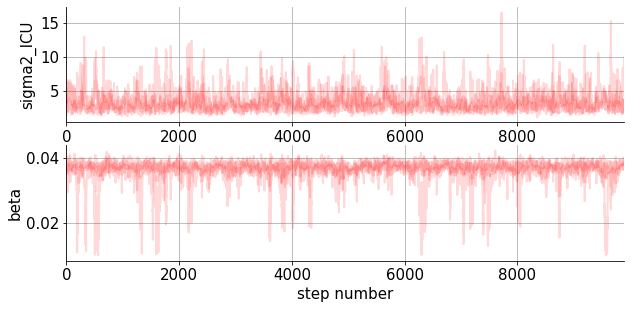

In [23]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
#legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

# Calibrating the compliance ramp parameters

## Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [25]:
with open('../../data/interim/model_parameters/arrondissements/'+arrondissement+'_'+readin_date+'.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [26]:
samples_dict.keys()

dict_keys(['lag_time', 'beta', 'start_date', 'end_beta', 'calibration_data'])

In [27]:
samples_beta = {'beta': samples_dict['beta']}

## Initial guess with PSO

In [28]:
# Create checkpoints dictionary
chk_beta_pso = {
    'time':  [lag_time], 
    'Nc':    [0.2*Nc_home + 0.3*Nc_work + 0.2*Nc_transport],
}
# define dataset
data=[arrond_ts[start_date:end_ramp]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk_beta_pso,samples=samples_beta,maxiter=50,popsize=50)

No constraints given.
Best after iteration 1: [16.36926882 10.3384933  10.97592118  0.44224627] 108.85301906145808
Best after iteration 2: [16.36926882 10.3384933  10.97592118  0.44224627] 108.85301906145808
Best after iteration 3: [16.36926882 10.3384933  10.97592118  0.44224627] 108.85301906145808
New best for swarm at iteration 4: [11.34521568 13.06474785  2.87821012  0.33852419] 96.25695958088652
Best after iteration 4: [11.34521568 13.06474785  2.87821012  0.33852419] 96.25695958088652
New best for swarm at iteration 5: [6.50448266 8.20451477 0.         0.2673398 ] 92.78908660430773
Best after iteration 5: [6.50448266 8.20451477 0.         0.2673398 ] 92.78908660430773
New best for swarm at iteration 6: [4.96951458 7.39530303 3.30495869 0.18065568] 78.40330938634558
Best after iteration 6: [4.96951458 7.39530303 3.30495869 0.18065568] 78.40330938634558
Best after iteration 7: [4.96951458 7.39530303 3.30495869 0.18065568] 78.40330938634558
New best for swarm at iteration 8: [4.1580

In [29]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2]

}
)
prevention = theta[2]
# Create checkpoints dictionary
chk_beta_MCMC = {
    'time':  [lag_time], 
    'Nc':    [prevention*(1.0*Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others
                          + 0.2*Nc_leisure)],
}

## MCMC calibration

In [30]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk_beta_MCMC,samples_beta))


In [ ]:
sampler.run_mcmc(pos, 1000, progress=True);#only 500 instead of 10000 steps (for a trial)

  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/miniconda3/envs/work/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 15/1000 [00:12<12:34,  1.31it/s]

In [ ]:
sampler.get_autocorr_time()

In [ ]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [ ]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist(), 'end_ramp':end_ramp})

In [ ]:
with open('../../data/interim/model_parameters/deterministic_'+str(datetime.date.today())+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [ ]:
mean = np.mean(flat_samples[:,3])
p10 = np.percentile(flat_samples[:,3],10)
p90 = np.percentile(flat_samples[:,3],90)
print(mean,p10,p90)

In [ ]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(1000):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.05)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
#plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

## Result

In [ ]:
data_after_calib

In [ ]:
states = [['H_in']]
start_date = '15-03-2020'
end_date = '2020-09-20'
data=[arrond_ts[start_date:end_ramp].values]
fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [start_date], 
          'Nc':      [prevention*(Nc_home + 0.4*Nc_work + 0.3*Nc_transport + 0.7*Nc_others + 0.2*Nc_leisure)]
          }
    y_model = model.sim(time=end_date, excess_time=lag_time,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,end_date=end_date,with_ints=False,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

data_after_calib = arrond_ts[pd.to_datetime(end_ramp)+pd.to_timedelta('1d'):end_date]
plt.scatter(data_after_calib.index, data_after_calib.values, marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
#ax.set_ylim([0,850])
ax.set_xlim(start_date, '2020-08-03')
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')
fig.savefig('../../results/calibrations_arrondissements/'+arrondissement+'_'+str(datetime.date.today())+'.png',
            bbox_inches='tight')

In [ ]:
fig.savefig('../../results/calibrations_arrondissements/'+arrondissement+'_'+str(datetime.date.today())+'.png',
            bbox_inches='tight', dpi=600)

# (Calibration of hospitalization parameters)

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [ ]:
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [ ]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 8

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(2,30),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=50)

In [ ]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4]
}
)

In [ ]:
T = 3
fig,ax=plt.subplots()
for i in range(1):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 1})

In [ ]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,500),(1,500),(1,1000),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 16000, progress=True);

In [ ]:
sampler.get_autocorr_time()

In [ ]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [ ]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

In [ ]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

In [ ]:
traceplot(samples=sampler.get_chain(discard=50),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);
fig.set_size_inches(12, 12)
plt.savefig('corner_compliance_hospitalization.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [ ]:
with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [ ]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

In [ ]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)